# Compare SEMITONES to singleCellHaystack and Seurat's default
Seurat's default is the Wilcoxon signed-rank test while fitlering out genes that are present in less than 0.1 percent of cells and have less than a 0.25 log(fold change)

## 1. Set up the notebook

In [1]:
import os
import numpy as np
import pandas as pd
#import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

from SEMITONES.support_funcs import load_sparse_h5

In [2]:
os.chdir("../data/processed/")

## 2. Load the data

In [3]:
semi = pd.read_csv("greenleaf_scRNA_escores_knn_rbf_8e-1.txt", sep="\t",
                   index_col=0)

In [4]:
sch = pd.read_csv("greenleaf_scRNA_singleCellHaystack_DE.txt", sep="\t")

In [5]:
wilcx = pd.read_csv("greenleaf_scRNA_Seurat_DE_filtered.txt", sep="\t")

In [6]:
# expression and UMAP
fname = "greenleaf_scRNA_combined_expressed_logcnorm.h5"
X = load_sparse_h5("scRNA", fname).tocsr()

with open("greenleaf_scRNA_combined_expressed_genes.txt", "r") as f:
    genes = [g.strip("\n") for g in f.readlines()]
f.close()

UMAP = np.load("greenleaf_scRNA_combined_umap.npy")

## 3. Compare SEMITONES to singleCellHaystack

### a. Rank the data

In [7]:
semi_ranks = semi.abs().rank(ascending=False, method="dense").min(1)

In [8]:
sch_ranks = sch.loc[:, "log.p.adj"].rank(method="dense")

In [9]:
assert (semi_ranks.index == sch_ranks.index).all()

In [10]:
semisch_ranks = pd.DataFrame([semi_ranks.values, sch_ranks.values],
                             index=["SEMITONES", "singleCellHaystack"],
                             columns=semi_ranks.index).T

### b. Check the ratio of SEMITONES rank over the singleCellHaystack rank

In [11]:
semisch_ranks["ratio"] = semisch_ranks.SEMITONES / semisch_ranks.singleCellHaystack

In [12]:
# higher SEMITONES than singleCellHaystack rank
semisch_ranks.sort_values(by="ratio").index[:10]

Index(['PRSS1', 'TNFRSF17', 'CLC', 'GPRC5D', 'KIFC1', 'CDKN1C', 'AHSP', 'HDC',
       'SCT', 'CLEC10A'],
      dtype='object')

In [13]:
# higher singleCellHaystack than singleCellHaystack rank
semisch_ranks.sort_values(ascending=False, by="ratio").index[:10]

Index(['CSTA', 'FCN1', 'FGR', 'CD68', 'PRAM1', 'CFD', 'LMO2', 'LY86', 'CD302',
       'CREG1'],
      dtype='object')

### c. Check where SEMITONES and singleCellHaystack ranks co-occur

In [14]:
semisch_size = semisch_ranks.groupby(["SEMITONES", "singleCellHaystack"]
                                    ).size()

In [15]:
semisch_ranks["N"] = 0
for (i_a, i_b), n in zip(semisch_size.index, semisch_size.values):
    vec = ((semisch_ranks.SEMITONES == i_a) &
           (semisch_ranks.singleCellHaystack == i_b)).values
    semisch_ranks.loc[vec, "N"] = n

### d. Visualize the SEMITONES versus singleCellHaystack ranks

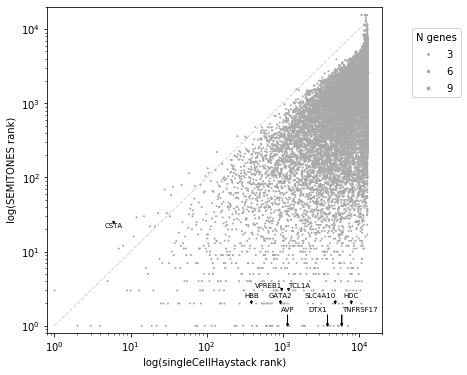

In [16]:
fig = plt.figure(figsize=(6, 6))
# plot singleCellHaystack ranks versus ranks SEMITONES
sc = plt.scatter(x=semisch_ranks.singleCellHaystack,
                 y=semisch_ranks.SEMITONES,
                 s=semisch_ranks.N,  # size by N of genes here
                 color="darkgrey")
plt.xlabel("log(singleCellHaystack rank)", fontsize=10)
plt.ylabel("log(SEMITONES rank)", fontsize=10)

# plot the unity line for reference
x = np.linspace(1, np.max(semisch_ranks.singleCellHaystack))
plt.plot(x, x, color="lightgrey", ls="--", linewidth=1, zorder=0)

# plot legend for marker size
leg = plt.legend(*sc.legend_elements("sizes", num=3, color="darkgrey"),
                 title="N genes", bbox_to_anchor=(.2,-.05,1.05,1))

# annotate genes
annot = ["HDC", "SLC4A10", "TNFRSF17", "AVP", "GATA2", "CSTA",
         "VPREB1", "TCL1A", "DTX1", "HBB"]
hzalign = ["center", "right", "left", "center", "center", "center",
           "right", "left", "right", "center"]
ax = plt.gca()  # get current axis
for gene, ha in zip(annot, hzalign):
    ax.annotate(gene,
                (semisch_ranks.singleCellHaystack[gene],
                 semisch_ranks.SEMITONES[gene]),
                xytext=(semisch_ranks.singleCellHaystack[gene],
                        semisch_ranks.SEMITONES[gene] + .8),
                arrowprops=dict(facecolor="black", headwidth=2,
                                headlength=2, width=.05),
                fontsize=7, horizontalalignment=ha, verticalalignment="top")

# stylize the plot
plt.xlim(0.8, 2e4)
plt.ylim(0.8, 2e4)
plt.yscale("log")
plt.xscale("log")

## 4. Compare SEMITONES to Seurat's default

### a. Rank the data

#### i. Get the lowest p-value for each gene in Seurat

In [17]:
min_idx = wilcx.groupby("gene").p_val_adj.idxmin().values  # lowest q index
wilcx_ranks = wilcx.loc[min_idx, :].set_index("gene")  # subset for lowest q
wilcx_ranks = wilcx_ranks.loc[:, "p_val_adj"].rank(method="dense")  # rank

#### ii. Subset SEMITONES for the genes that passed Seurat's filtering

In [18]:
semi_sub = semi_ranks.loc[wilcx_ranks.index]

#### iii. Combine ranks

In [19]:
semiwil_ranks = pd.DataFrame([semi_sub.values, wilcx_ranks.values],
                             index=["SEMITONES", "Wilcoxon"],
                             columns=semi_sub.index).T

### b. Check the ratio of SEMITONES rank over the Seurat rank

In [20]:
semiwil_ranks["ratio"] = semiwil_ranks.SEMITONES / semiwil_ranks.Wilcoxon

In [21]:
# higher SEMITONES than Wilcoxon rank
semiwil_ranks.sort_values(by="ratio").index[:10]

Index(['NUSAP1', 'BIRC5', 'LMO4', 'IGSF6', 'RRM2', 'RGS1', 'PDIA4', 'SLC44A1',
       'SEC11C', 'HBA2'],
      dtype='object', name='gene')

In [22]:
# higher Wilcoxon than SEMITONES rank
semiwil_ranks.sort_values(ascending=False, by="ratio").index[:10]

Index(['HNRNPDL', 'MZT2A', 'SNRPD2', 'LAMTOR1', 'MZT2B', 'PSIP1', 'ATP6V0E1',
       'BNIP3L', 'CAPNS1', 'COX6C'],
      dtype='object', name='gene')

In [23]:
### c. Check where SEMITONES and Seurat ranks co-occur

In [24]:
semiwil_size = semiwil_ranks.groupby(["SEMITONES", "Wilcoxon"]).size()

In [25]:
semiwil_ranks["N"] = 0
for (i_a, i_b), n in zip(semiwil_size.index, semiwil_size.values):
    vec = ((semiwil_ranks.SEMITONES == i_a) &
           (semiwil_ranks.Wilcoxon == i_b)).values
    semiwil_ranks.loc[vec, "N"] = n

### d. Plot SEMITONES versus Seurat ranks

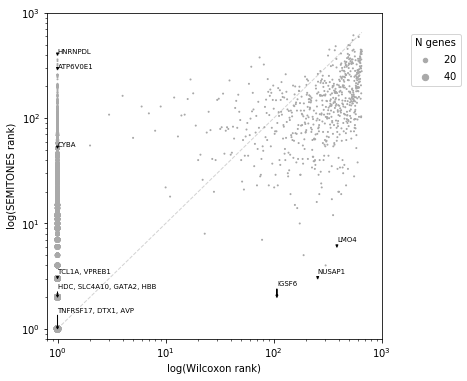

In [26]:
fig = plt.figure(figsize=(6, 6))
# plot Seurat ranks versus ranks SEMITONES
sc = plt.scatter(x=semiwil_ranks.Wilcoxon,
                 y=semiwil_ranks.SEMITONES,
                 s=semiwil_ranks.N,  # size by N of genes here
                 color="darkgrey")
plt.xlabel("log(Wilcoxon rank)", fontsize=10)
plt.ylabel("log(SEMITONES rank)", fontsize=10)

# plot the unity line for reference
x = np.linspace(1, np.max(semiwil_ranks.Wilcoxon))
plt.plot(x, x, color="lightgrey", ls="--", linewidth=1, zorder=0)

# plot legend for marker size
leg = plt.legend(*sc.legend_elements("sizes", num=3, color="darkgrey"),
                 title="N genes", bbox_to_anchor=(.2,-.05,1.05,1))

# annotate genes
annot_gene = ["TNFRSF17", "HDC", "TCL1A",
              "ATP6V0E1", "CYBA", "HNRNPDL",
              "LMO4", "IGSF6", "NUSAP1"]
annot_label = ["TNFRSF17, DTX1, AVP", "HDC, SLC4A10, GATA2, HBB",
               "TCL1A, VPREB1",
               "ATP6V0E1", "CYBA", "HNRNPDL",
               "LMO4", "IGSF6", "NUSAP1"]
hzalign = ["left", "left", "left",
           "left", "left", "left",
           "left", "left", "left"]
ax = plt.gca()
for gene, label, ha in zip(annot_gene, annot_label, hzalign):
    adj = 0
    tops = ["TNFRSF17", "HDC", "TCL1A", "NUSAP1", "SNRPD2"]
    va = "center" if gene in tops else "bottom"
    ax.annotate(label, (semiwil_ranks.Wilcoxon[gene],
                        semiwil_ranks.SEMITONES[gene]),
                xytext=(semiwil_ranks.Wilcoxon[gene] + adj,
                        semiwil_ranks.SEMITONES[gene] + .5),
                arrowprops=dict(facecolor="black", headwidth=2,
                                headlength=2, width=.05),
                fontsize=7, horizontalalignment=ha, verticalalignment=va)

# stylize the plot
plt.xlim(0.8, 1e3)
plt.ylim(0.8, 1e3)
plt.yscale("log")
plt.xscale("log")

### 5. Plot expression values for genes with wildly different rankings

In [27]:
toplot = ["HDC", "SLC4A10", "TNFRSF17", "AVP", "GATA2", "CSTA", "VPREB1",
          "TCL1A", "DTX1", "HBB", "ATP6V0E1", "CYBA", "HNRNPDL", "LMO4",
          "IGSF6", "NUSAP1"]

In [28]:
# make a custom colour map
oranges = cm.get_cmap("Oranges", 256)
GrOr = oranges(np.linspace(0, 1, 256))
Gr = LinearSegmentedColormap.from_list(
    "Gr",
    [(230/256, 230/256, 230/256, 1),
     (GrOr[11, :][0], GrOr[11, :][1], GrOr[11, :][2], GrOr[11, :][3])],
    N=50)
Gr = cm.get_cmap(Gr, 50)
Gr = Gr(np.linspace(0, 1, 50))
GrOr[:50, :] = Gr
GrOr = ListedColormap(GrOr)

In [29]:
ncols = 3
nrows = len(toplot) / ncols

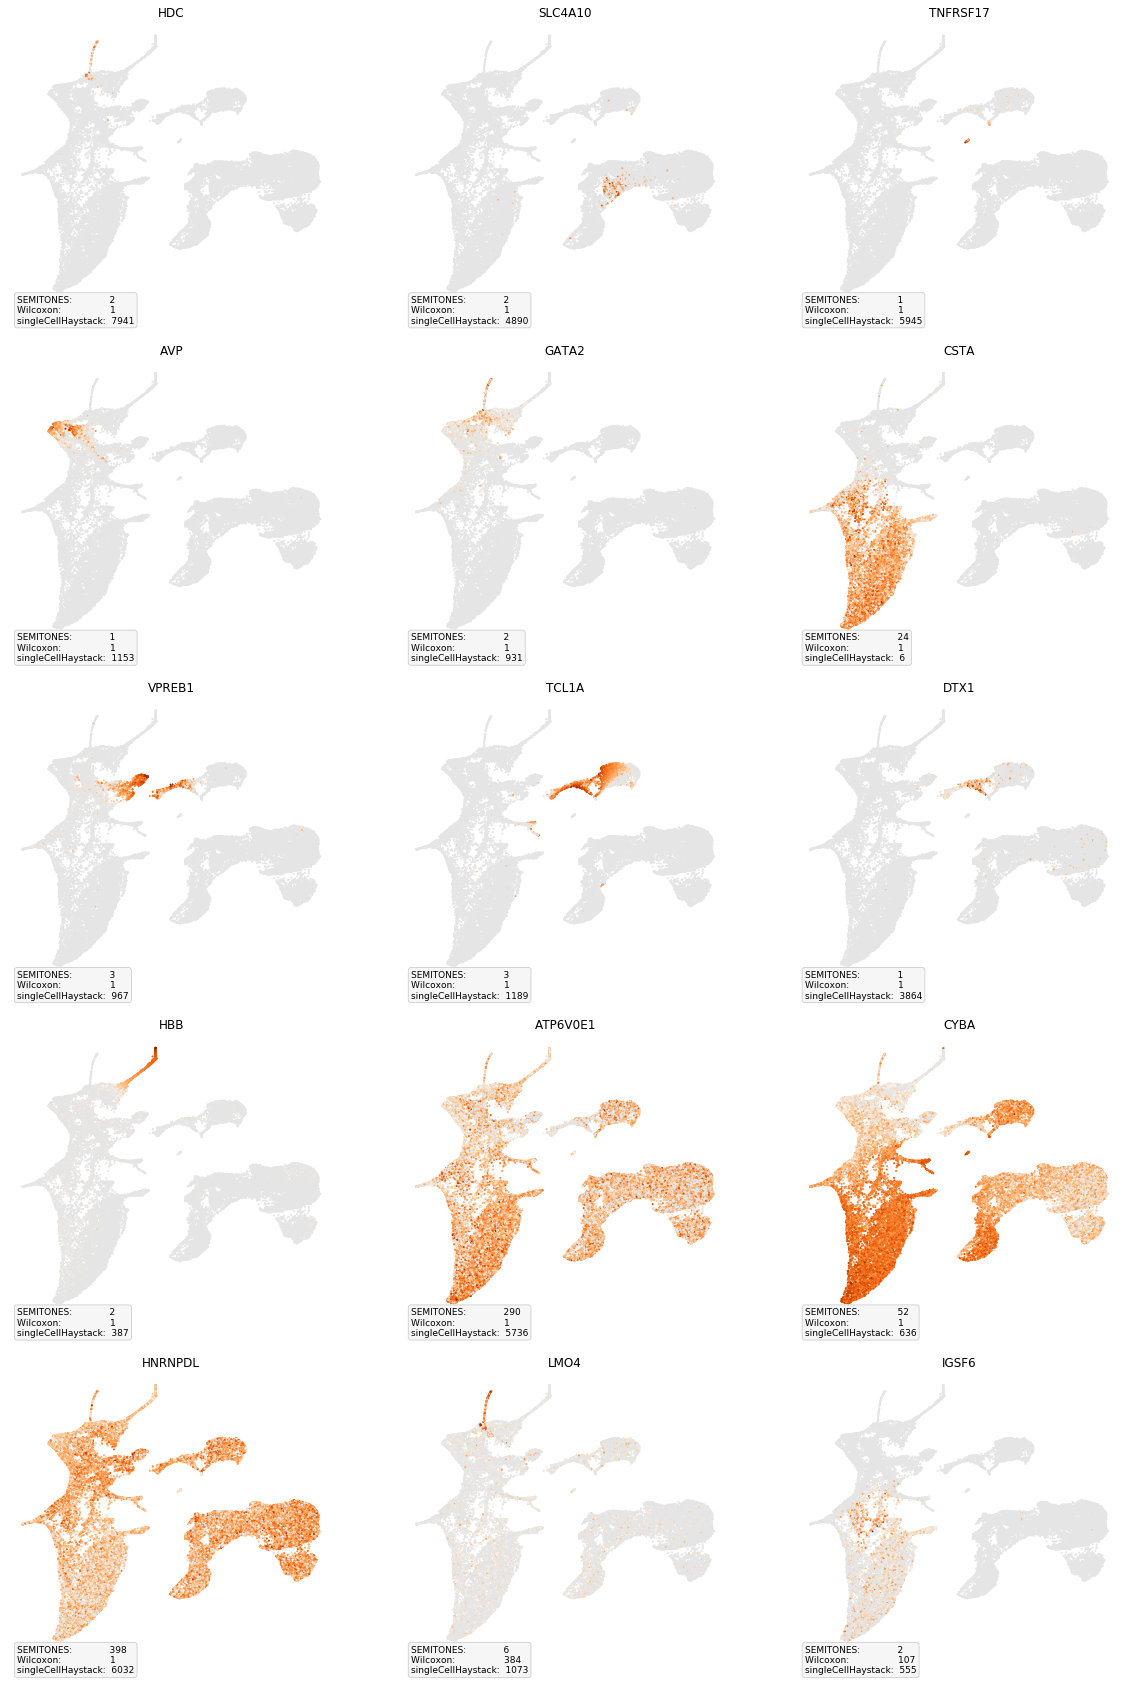

In [30]:
fig, axs = plt.subplots(nrows=round(nrows), ncols=ncols)
fig.set_figwidth(20)
fig.set_figheight(30)
for ax, gene in zip(axs.ravel(), toplot):
    # plot expression
    ax.scatter(UMAP[:, 0], UMAP[:, 1], c=X[:, genes.index(gene)].A.ravel(),
               s=1, cmap=GrOr)
    ax.set_title(gene, fontsize=12)

    # plot ranks for all methods
    t1 = f"SEMITONES:             {int(semi_ranks[gene])}\n"
    t2 = f"Wilcoxon:                 {int(wilcx_ranks[gene])}\n"
    t3 = f"singleCellHaystack:  {int(sch_ranks[gene])}"
    text = t1 + t2 + t3
    ax.text(.03, .03, text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightgrey',
                      alpha=0.2, linewidth=.75))

    # stylize
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_frame_on(False)